# Appendix

## Imports

In [2]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

from Tracker_functions import (
    getROIFromVideo,
    cropWithROI,
    getTemplatesFromVideo,
    getTemplateMatches,
    getOutputVidFrameSize,
)

import time
import numpy as np
import imutils
from natsort import natsorted
import multiprocessing
import pandas as pd
from scipy.optimize import curve_fit, least_squares
from scipy.signal import find_peaks
from sklearn.metrics import r2_score

%reload_ext autoreload
%autoreload 0

## Crop Video

In [ ]:
vid_path = Path("pendulum.mp4")
crop_roi = getROIFromVideo(str(vid_path))
cv2.destroyAllWindows()

## Difficult to Threshold

In [ ]:
VID_PATH = Path("pendulum.mp4")
OUTPUT_VID_PATH = VID_PATH.parent / (VID_PATH.stem + "_thresh_output.mp4")
OUTPUT_HEIGHT = 800
# pipeline = lambda frame: frame
# pipeline = lambda frame: cv2.warpPerspective(frame, M, (imgWidth, imgHeight))
pipeline = lambda frame: cropWithROI(frame, crop_roi)

IMSHOW_FLAG = True
WRITE_FLAG = True

cap = cv2.VideoCapture(str(VID_PATH))
fps = cap.get(cv2.CAP_PROP_FPS)

frameWidth, frameHeight = getOutputVidFrameSize(str(VID_PATH), pipeline, OUTPUT_HEIGHT)
out = cv2.VideoWriter(
    str(OUTPUT_VID_PATH),
    cv2.VideoWriter_fourcc(*"mp4v"),
    cap.get(cv2.CAP_PROP_FPS),
    (frameWidth, frameHeight),
)

totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
frameCount = 0
startTime = time.time()
saveFrames = []
saveCnts = []
centroids = []

ret, frame = cap.read()
while ret:
    if frameCount % 100 == 0 and frameCount != 0:
        elapsedTime = time.time() - startTime
        estTimeLeft = (totalFrames - frameCount) / frameCount * elapsedTime
        print(f"Frame {frameCount} out of {round(totalFrames)}.")
        print(
            f"\tTime taken: {round(elapsedTime)}s. Est. time left: {round(estTimeLeft)}s"
        )

    frame = pipeline(frame)
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    (frame_h, frame_s, frame_v) = cv2.split(frame_hsv)

    frame = imutils.resize(frame, height=OUTPUT_HEIGHT)

    if WRITE_FLAG:
        out.write(frame)

    if IMSHOW_FLAG:
        cv2.imshow("Hue", frame_h)
        cv2.imshow("Saturation", frame_s)
        cv2.imshow("Value", frame_v)
        key = cv2.waitKey(10)

        if key == ord("q") or key == ord("Q"):
            break

        if key == ord("p") or key == ord("P"):
            key = cv2.waitKey(0)
            if key == ord("p") or key == ord("P"):
                continue

    ret, frame = cap.read()
    frameCount += 1

cv2.destroyAllWindows()
out.release()
cap.release()

## Not Circular

## Get Template(s)

In [ ]:
# pipeline = lambda frame: cv2.warpPerspective(cropWithROI(frame, crop_roi), M, (imgWidth, imgHeight))
pipeline = lambda frame: cropWithROI(frame, crop_roi)
# pipeline = lambda frame: frame
templates = getTemplatesFromVideo(
    str(vid_path), pipeline, templateWidth=70, templateHeight=70
)

## Save Template(s)

In [ ]:
# templatesDir = Path("templates_pendulum")
templatesDir = Path("templates_pendulum2")
templatesDir.mkdir(exist_ok=True)

imgPaths = natsorted([str(path) for path in templatesDir.glob("*.jpg")])

if imgPaths:
    latestImgN = int(Path(imgPaths[-1]).stem) + 1
else:
    latestImgN = 0

for i in range(len(templates)):
    cv2.imwrite(str(templatesDir / f"{latestImgN+i}.jpg"), templates[i])

templates.clear()

## Load Template(s)

In [ ]:
# templatesDir = Path("templates_pendulum/")
templatesDir = Path("templates_pendulum2")

imgPaths = templatesDir.glob("*.jpg")

templates = []
for imgPath in imgPaths:
    template = cv2.imread(str(imgPath))
    templates.append(template)
    cv2.imshow("Template", template)
    cv2.waitKey(0)

cv2.waitKey(0)
cv2.destroyAllWindows()

## Match Templates

In [ ]:
VID_PATH = Path("data/pendulum.mp4")
# OUTPUT_VID_PATH = VID_PATH.parent / (VID_PATH.stem + "_output.mp4")
OUTPUT_VID_PATH = VID_PATH.parent / (VID_PATH.stem + "_output2.mp4")

OUTPUT_HEIGHT = 800

# NMS_THRESHOLD = 0.7
NMS_THRESHOLD = 0.3
CONFIDENCE_THRESHOLD = 0.775

IMSHOW_FLAG = True
WRITE_FLAG = True

num_cpu = multiprocessing.cpu_count() - 1
pool = multiprocessing.pool.ThreadPool(processes=num_cpu)

cap = cv2.VideoCapture(str(VID_PATH))

totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
frameCount = 0
startTime = time.time()

# pipeline = lambda frame: frame
pipeline = lambda frame: cropWithROI(frame, crop_roi)
# pipeline = lambda frame: cv2.warpPerspective(cropWithROI(frame, crop_roi), M, (imgWidth, imgHeight))

frameWidth, frameHeight = getOutputVidFrameSize(str(VID_PATH), pipeline, OUTPUT_HEIGHT)
out = cv2.VideoWriter(
    str(OUTPUT_VID_PATH),
    cv2.VideoWriter_fourcc(*"mp4v"),
    cap.get(cv2.CAP_PROP_FPS),
    (frameWidth, frameHeight),
)
print(f"Output frame width: {frameWidth}, frame height: {frameHeight}")

saveFrames = []
saveBoxes = []

ret, frame = cap.read()
while ret:
    if frameCount % 100 == 0 and frameCount != 0:
        elapsedTime = time.time() - startTime
        estTimeLeft = (totalFrames - frameCount) / frameCount * elapsedTime
        print(f"Frame {frameCount} out of {round(totalFrames)}.")
        print(
            f"\tTime taken: {round(elapsedTime)}s. Est. time left: {round(estTimeLeft)}s"
        )

    img_rgb = pipeline(frame)

    # Multithreading
    mapIterable = []
    for i in range(len(templates)):
        template = templates[i]
        mapIterable.append((img_rgb, template, CONFIDENCE_THRESHOLD))
    results = pool.starmap(func=getTemplateMatches, iterable=mapIterable)

    boxes, confidences = [], []
    for result in results:
        boxes.extend(result[0])
        confidences.extend(result[1])

    # Sequential
    # boxes, confidences = [], []
    # for template in templates:
    #     val = getTemplateMatches(img_rgb, template, CONFIDENCE_THRESHOLD)
    #     boxes.extend(val[0])
    #     confidences.extend(val[1])

    indices = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
    boxes = [boxes[idx] for idx in indices]
    confidences = [confidences[idx] for idx in indices]

    if boxes:
        saveFrames.append(frameCount)
        saveBoxes.append(boxes[0].copy())

    for box in boxes:
        cv2.rectangle(img_rgb, box[:2], box[2:], (0, 0, 255), 2)

    img_rgb = imutils.resize(img_rgb, height=OUTPUT_HEIGHT)

    if WRITE_FLAG:
        out.write(img_rgb)

    if IMSHOW_FLAG:
        cv2.imshow("Detections", img_rgb)
        key = cv2.waitKey(1)
        if key == ord("q") or key == ord("Q"):
            break

    ret, frame = cap.read()
    frameCount += 1

cv2.destroyAllWindows()
out.release()
cap.release()

## Export Data

In [ ]:
csv_path = VID_PATH.parent / (VID_PATH.stem + "_output2.csv")

pix_per_metre = 1
coords = (
    np.array([[(b[0] + b[2]) / 2, (b[1] + b[3]) / 2] for b in saveBoxes])
    / pix_per_metre
)

df = pd.DataFrame([saveFrames, coords[:, 0], coords[:, 1]]).T
df.to_csv(csv_path, index=None, header=["frame", "x", "y"])

# Curve Fitting

## Load Data

In [19]:
csv_path = "pendulum_output2.csv"

df = pd.read_csv(csv_path)
frame = df["frame"]
# We need to swap the x and y values because the video is not in the right orientation.
x = max(df["y"]) - df["y"]
y = max(df["x"]) - df["x"]

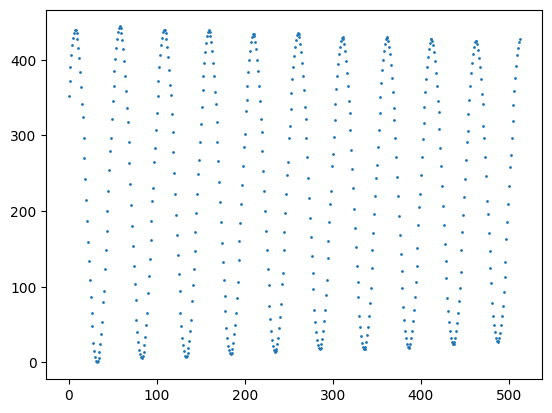

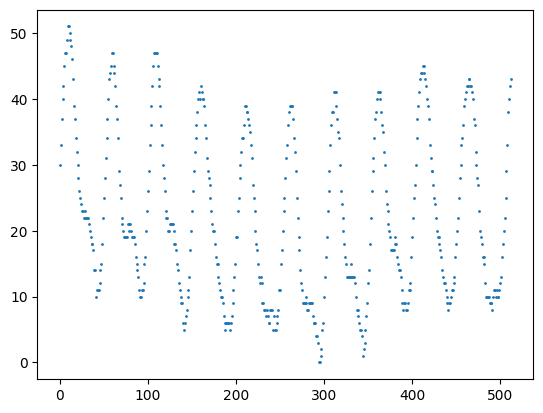

In [20]:
plt.scatter(frame, x, s=1)
plt.show()
plt.scatter(frame, y, s=1)
plt.show()

# Try fitting 
$A \sin(2\pi f t + \alpha)$

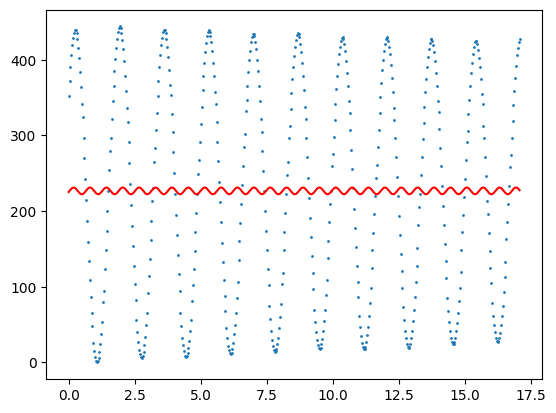

In [21]:
FPS = 30
t = frame / FPS


def func(t, A, f, alpha, offset):
    return A * np.sin(2 * np.pi * f * t + alpha) + offset


popt, _ = curve_fit(func, t, x)
plt.scatter(t, x, s=1)
plt.plot(t, func(t, *popt), color="r", label="Best Fit")

In [22]:
r2_score(x, func(t, *popt))

0.000447081990529008

# Oh no bad fit!

#### The data under-determines our model. But we can find the frequency of the sine wave using a different (more-reliable and more scalable) method.

Using find_peaks, we locate the points on the graph that correspond to the peaks and troughs of the wave. By comparing the time difference between these points, we can find the period of oscillation, which then translates to frequency.

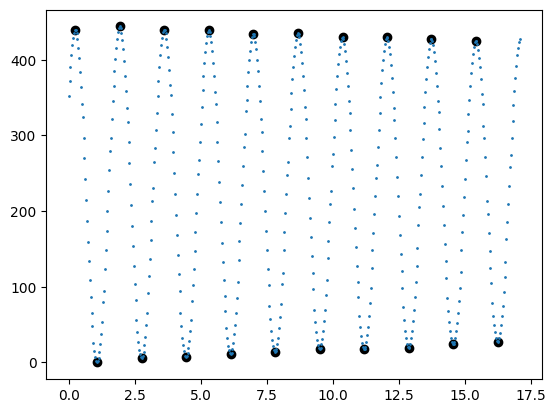

In [10]:
peaks, _ = find_peaks(x)
troughs, _ = find_peaks(-x)
crit_pts = np.append(peaks, troughs)
t_crit, x_crit = t[crit_pts], x[crit_pts]

plt.scatter(t_crit, x_crit, color="k", label="peaks")
plt.scatter(t, x, s=1)

period = np.mean(np.diff(sorted(t_crit))) * 2
freq = 1 / period

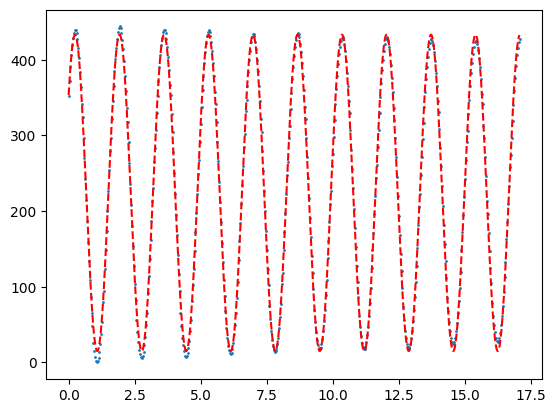

In [23]:
def func(t, A, alpha, offset):
    return A * np.sin(2 * np.pi * freq * t + alpha) + offset


t_lin = np.linspace(min(t), max(t), 1000)

popt, pcov = curve_fit(func, t, x)
plt.scatter(t, x, s=1)
plt.plot(t_lin, func(t_lin, *popt), color="r", linestyle="--", label="Best Fit")
plt.show()

In [24]:
r2_score(x, func(t, *popt))

0.9981559936573439

#### As we can see, this approach allows us to reliably determine the frequency of the oscillation, allowing for more accurate curve fitting.

# An even better model!

#### An underdamped pendulum decays in amplitude exponentially​  

\begin{align} \large \theta_{max}(t) = \theta_{0} e^{-\frac{\eta t}{2m}}  \end{align}

##### $ \eta $ : air drag constant ($ kg \cdot s^{-1} $)

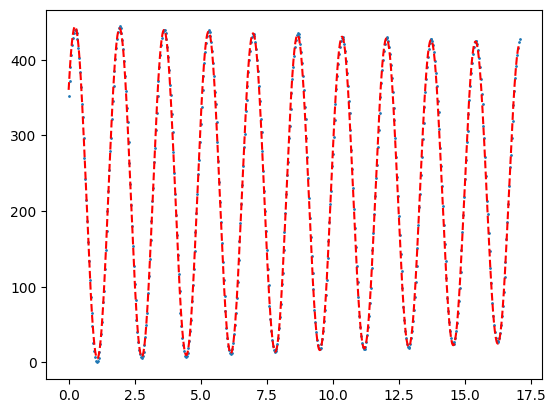

In [14]:
def func(t, A, alpha, offset, m):
    return A * (np.exp(m * t)) * np.sin(2 * np.pi * freq * t + alpha) + offset


t_lin = np.linspace(min(t), max(t), 1000)

popt, pcov = curve_fit(func, t, x)
plt.scatter(t, x, s=1)
plt.plot(t_lin, func(t_lin, *popt), color="r", linestyle="--", label="Best Fit")
plt.show()

In [15]:
r2_score(x, func(t, *popt))

0.9991140763683156

# Account for rotation

#### The video taken is slightly tilted: the x-axis of the frame doesn't align perfectly with the horizon. This can be seen from the graph below, where the pendulum is higher on the right end of the oscillation than the left end of the oscillation (by right, they should be symmetric). We can perform a matrix multiplication to rotate the video to correct for this tilt.

Text(0, 0.5, 'y position')

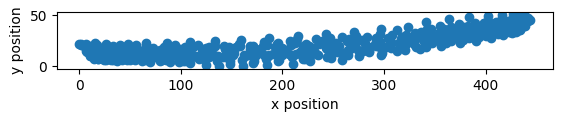

In [27]:
plt.scatter(x, y)
plt.gca().set_aspect("equal")
plt.xlabel("x position")
plt.ylabel("y position")

In [31]:
xy = np.array([x, y]).T
rotation_matrix = lambda a: np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])


def rotate(a):
    return xy @ rotation_matrix(a).T


def error_fn(a):
    rotated_xy = rotate(a)
    rotated_y = rotated_xy[0, :, 1]
    return rotated_y


angle_estimate = 0
res = least_squares(error_fn, angle_estimate)
angle = res.x
np.rad2deg(angle)

array([-5.18469763])

#### So, we need to rotate the whole trajectory of the pendulum by about -5.18 degrees to level video with the horizon.

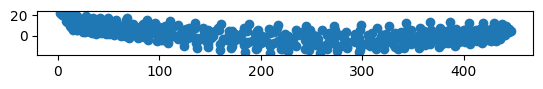

In [32]:
rotated_xy = rotate(angle)
x_rotated, y_rotated = rotated_xy[0].T
plt.scatter(x_rotated, y_rotated)
plt.gca().set_aspect("equal")

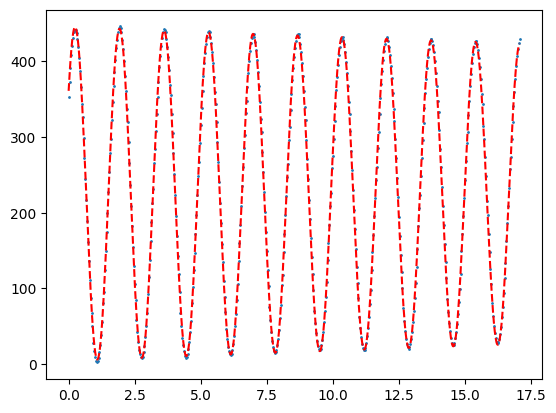

In [33]:
def func(t, A, alpha, offset, m):
    return A * (np.exp(m * t)) * np.sin(2 * np.pi * freq * t + alpha) + offset


t_lin = np.linspace(min(t), max(t), 1000)

popt, pcov = curve_fit(func, t, x_rotated)
plt.scatter(t, x_rotated, s=1)
plt.plot(t_lin, func(t_lin, *popt), color="r", linestyle="--", label="Best Fit")

In [34]:
r2_score(x_rotated, func(t, *popt))

0.9991946252330791

#### Haha, all these effort to improve the r^2 score by 0.9991946252330791 - 0.9991140763683156 = 8.054886476349665e-05

# Making predictions with the data!

#### From this video alone, we can actually predict the maximum angular displacement of the pendulum, as well as the length of the string that the pendulum bulb is attached to. Physics is powerful!

#### Using some geometric reasoning, we can find the maximum angular displacement $\theta_{0}$ of the pendulum and length of string $R$ by solving these equations below, where:


H = vertical displacement of the pendulum (height)

W = horizontal displacement of the pendulum (width)

$$
H sin(θ_{0}) + W cos(θ_{0}) - W = 0
$$

$$
R [1 - cos(sin^{-1}(\frac{W}{R}))] - H = 0
$$
$$
R [1 - \sqrt{1 - \frac{W^2}{R^2}}] - H = 0
$$

$$
R = \frac{W}{sin(θ_{0})}
$$

W: 222.0, H: 40


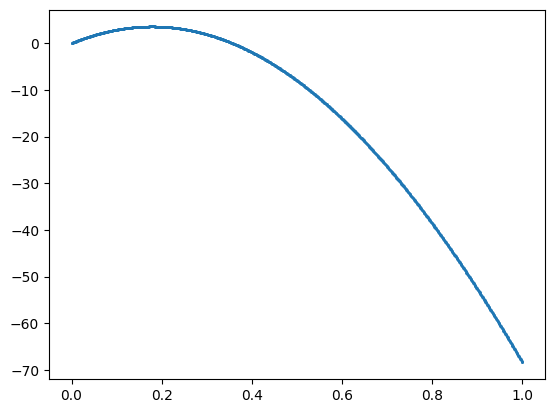

/var/folders/9n/n42mcm4j3zd6tllvscs4_ych0000gn/T/ipykernel_40148/2344854383.py:10: RuntimeWarning: divide by zero encountered in divide
  return R * ( 1 - np.sqrt(1 - (W**2 / R**2)) ) - H
/var/folders/9n/n42mcm4j3zd6tllvscs4_ych0000gn/T/ipykernel_40148/2344854383.py:10: RuntimeWarning: invalid value encountered in sqrt
  return R * ( 1 - np.sqrt(1 - (W**2 / R**2)) ) - H


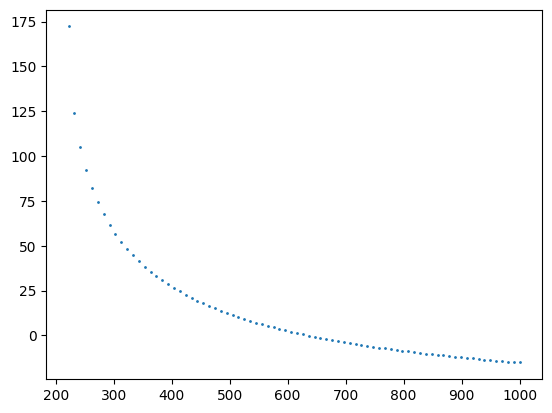

 message: The solution converged.
 success: True
  status: 1
     fun: [-2.842e-14]
       x: [ 3.565e-01]
  method: hybr
    nfev: 8
    fjac: [[-1.000e+00]]
       r: [ 4.000e+01]
     qtf: [ 3.610e-12]
 message: The solution converged.
 success: True
  status: 1
     fun: [ 3.290e-12]
       x: [ 6.360e+02]
  method: hybr
    nfev: 8
    fjac: [[-1.000e+00]]
       r: [ 6.711e-02]
     qtf: [-3.129e-07]


theta_0 in degrees: 20.425945396413848
length of string: 636.1096343436546 units.


In [42]:
W = (max(x) - min(x))/2
H = 40
print(f"W: {W}, H: {H}")


def max_ang_disp(theta_0):
  return H*np.sin(theta_0) + W*np.cos(theta_0) - W

def len_pendulum_str(R):
  return R * ( 1 - np.sqrt(1 - (W**2 / R**2)) ) - H

from scipy.optimize import root

theta_lin = np.linspace(0, 1, 1000)
plt.scatter(theta_lin, max_ang_disp(theta_lin), s=1)
plt.show()

R_lin = np.linspace(0, 1000, 100)
plt.scatter(R_lin, len_pendulum_str(R_lin), s=1)
plt.show()



theta_0 = root(max_ang_disp, 0.4)
R = root(len_pendulum_str, 500)
print(theta_0)
print(R)
print("\n")
print(f"theta_0 in degrees: {3.565e-01 / np.pi * 180}")
print(f"length of string: {W/np.sin(3.565e-01)} units.")